# Logistic Regression 

## Hypothesis:  
Determine what features best predict which people identify themselves as "Data Scientists" based on the other features of the data.  

## Data: 
The data used for this project was obtained from Kaggle's recent survey across 16,000 professionals working in the field of Data Science.  The survey had multiple questions and responses from the population that help to define the true characteristics and values that make up a "Data Scientist".  The term "Data Scientist" has taken on multiple definitions, and in this project we attempt to determine what features ultimately define the people that actually call themselves by the name "Data Scientist". 

The data is available here:
https://www.kaggle.com/kaggle/kaggle-survey-2017/data


For this model we will be using feature selection and Logistic Regression. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from forex_python.converter import CurrencyRates
from time import sleep



import requests, json

%matplotlib inline

In [2]:
data_file = 'multipleChoiceResponses.csv'

In [3]:
df = pd.read_csv(data_file, encoding='latin-1', low_memory=False)

In [4]:
df.head()

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorExperienceLevel,JobFactorDepartment,JobFactorTitle,JobFactorCompanyFunding,JobFactorImpact,JobFactorRemote,JobFactorIndustry,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity
0,"Non-binary, genderqueer, or gender non-conforming",NaN,NaN,Employed full-time,NaN,NaN,Yes,NaN,DBA/Database Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Female,United States,30.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat important,NaN,NaN
2,Male,Canada,28.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important
3,Male,United States,56.0,"Independent contractor, freelancer, or self-em...",NaN,NaN,Yes,NaN,Operations Research Practitioner,Poorly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Male,Taiwan,38.0,Employed full-time,NaN,NaN,Yes,NaN,Computer Scientist,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sorted(df.columns)

['Age',
 'AlgorithmUnderstandingLevel',
 'BlogsPodcastsNewslettersSelect',
 'CareerSwitcher',
 'CodeWriter',
 'CompensationAmount',
 'CompensationCurrency',
 'Country',
 'CoursePlatformSelect',
 'CurrentEmployerType',
 'CurrentJobTitleSelect',
 'DataScienceIdentitySelect',
 'EmployerIndustry',
 'EmployerMLTime',
 'EmployerSearchMethod',
 'EmployerSize',
 'EmployerSizeChange',
 'EmploymentStatus',
 'FirstTrainingSelect',
 'FormalEducation',
 'GenderSelect',
 'HardwarePersonalProjectsSelect',
 'JobFactorCommute',
 'JobFactorCompanyFunding',
 'JobFactorDepartment',
 'JobFactorDiversity',
 'JobFactorExperienceLevel',
 'JobFactorImpact',
 'JobFactorIndustry',
 'JobFactorLanguages',
 'JobFactorLeaderReputation',
 'JobFactorLearning',
 'JobFactorManagement',
 'JobFactorOffice',
 'JobFactorPublishingOpportunity',
 'JobFactorRemote',
 'JobFactorSalary',
 'JobFactorTitle',
 'JobFunctionSelect',
 'JobHuntTime',
 'JobSatisfaction',
 'JobSearchResource',
 'JobSkillImportanceBigData',
 'JobSkillImpo

In [6]:
label = "DataScienceIdentitySelect"

Based on the available information in the data set, we are selecting the following features.  We will transform the features and then select the best features that will tell us whether or not it is a good indicator of whether or not someone would consider themselves a Data Scientist.

In [7]:
df.dropna(subset=["Age",
                  "FormalEducation", 
                  "WorkToolsFrequencyJupyter",
                  "WorkToolsFrequencyPython",
                  "CurrentJobTitleSelect",
                  "EmploymentStatus",
                  "EmployerIndustry",
                  "MajorSelect", 
                  "Tenure",
                  "EmploymentStatus",
                  "AlgorithmUnderstandingLevel",
                  "PastJobTitlesSelect",
                  "ParentsEducation",
                  label], inplace=True)

In [8]:
features = pd.DataFrame()

In [9]:
c = CurrencyRates()

df['CompensationAmount']=df['CompensationAmount'].str.replace(',', '')
df['CompensationAmount']=df['CompensationAmount'].str.replace('-', '')
df['CompensationAmount']=df['CompensationAmount'].str.strip()

df['CompensationCurrency']=df['CompensationCurrency'].fillna(0)
df['CompensationAmount']=df['CompensationAmount'].fillna(0)

for index, row in df.iterrows():
    if(row['CompensationAmount'] == ""):
        df.loc[index, 'NormalizedCurrency'] = 0
    elif int(row['CompensationCurrency'] == 0) | (int(row['CompensationAmount']) == 0):
        df.loc[index, 'NormalizedCurrency'] = 0
    else:
        if row['CompensationCurrency'] in ('TWD', 'PEN','CLP','ARS','AMD','AED','NPR','BDT','USD'):
            df.loc[index, 'NormalizedCurrency'] = row['CompensationAmount']
        else:
            try: 
                df.loc[index, 'NormalizedCurrency'] = c.convert('USD', row['CompensationCurrency'], float(row['CompensationAmount']))
            except:
                #wait a while
                sleep(10)


In [10]:
features = []
for col in df.columns:
    if col == 'Age' or col == 'DataScienceIdentitySelect' or col == 'NormalizedCurrency' or col == 'CompensationAmount' \
        or col == 'CompensationCurrency':
        continue
    new_df = pd.get_dummies(df[col])
    new_df.columns =["{}-{}".format(col, c) for c in new_df.columns]
    features.append(new_df)
features = pd.concat(features, axis=1)

In [11]:
features.head()

,GenderSelect-A different identity,GenderSelect-Female,GenderSelect-Male,"GenderSelect-Non-binary, genderqueer, or gender non-conforming",Country-Argentina,Country-Australia,Country-Belarus,Country-Belgium,Country-Brazil,Country-Canada,...,JobSatisfaction-10 - Highly Satisfied,JobSatisfaction-2,JobSatisfaction-3,JobSatisfaction-4,JobSatisfaction-5,JobSatisfaction-6,JobSatisfaction-7,JobSatisfaction-8,JobSatisfaction-9,JobSatisfaction-I prefer not to share
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
14,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
23,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In order to create somewhat decent bins of data, let's look at the histogram of the Age feature.

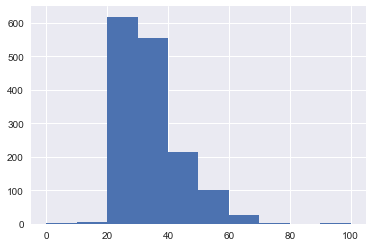

In [12]:
df.Age.hist()

In [13]:
age_bins = [0, 20, 30, 40, 50, 60, 100]
age_names = ['Age-0-20','Age-20-30','Age-30-40','Age-40-50','Age-50-60','Age-60-100']
categories = pd.cut(df['Age'], age_bins, labels=age_names)
age_categories = pd.get_dummies(categories)

In [14]:
features = pd.concat([features, age_categories], axis=1)

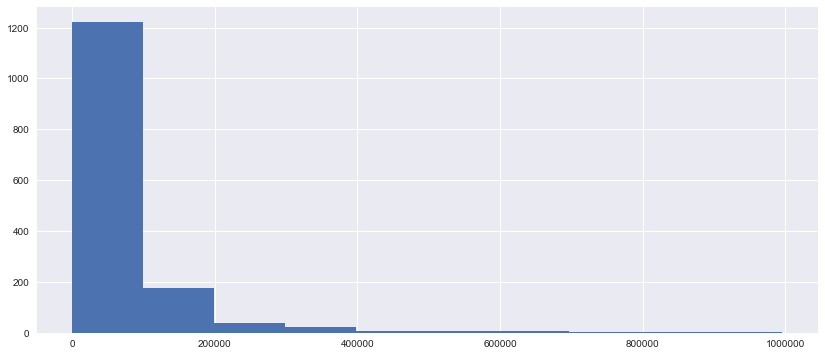

In [15]:
df.NormalizedCurrency = pd.to_numeric(df.NormalizedCurrency)
#  For some reason, when normalizing the currency, some values were extremely high.  
#  If this is true, I'm definitely moving to India
#  But under the assumption that this is really just a problem with the data, we're going to remove them.
df.loc[df['NormalizedCurrency'] >= 1000000] = 0
df.NormalizedCurrency.hist(figsize=(14,6))

In [16]:
currency_bins = [0, 100000, 200000, 400000, 600000, 800000, 1000000]
currency_names = ['Currency-0-100000','Currency-100000-200000','Currency-200000-400000','Currency-400000-600000','Currency-600000-800000','Currency-800000-1000000']
categories = pd.cut(df['NormalizedCurrency'], currency_bins, labels=currency_names)
currency_categories = pd.get_dummies(categories)

In [17]:
features = pd.concat([features, currency_categories], axis=1)

In [18]:
sorted(features.columns)

['Age-0-20',
 'Age-20-30',
 'Age-30-40',
 'Age-40-50',
 'Age-50-60',
 'Age-60-100',
 'AlgorithmUnderstandingLevel-Enough to code it again from scratch, albeit it may run slowly',
 'AlgorithmUnderstandingLevel-Enough to code it from scratch and it will run blazingly fast and be super efficient',
 'AlgorithmUnderstandingLevel-Enough to explain the algorithm to someone non-technical',
 'AlgorithmUnderstandingLevel-Enough to refine and innovate on the algorithm',
 'AlgorithmUnderstandingLevel-Enough to run the code / standard library',
 'AlgorithmUnderstandingLevel-Enough to tune the parameters properly',
 'BlogsPodcastsNewslettersSelect-Becoming a Data Scientist Podcast',
 'BlogsPodcastsNewslettersSelect-Becoming a Data Scientist Podcast,Data Elixir Newsletter,No Free Hunch Blog',
 'BlogsPodcastsNewslettersSelect-Becoming a Data Scientist Podcast,Data Elixir Newsletter,Partially Derivative Podcast',
 'BlogsPodcastsNewslettersSelect-Becoming a Data Scientist Podcast,Data Elixir Newsletter,

Now that we have the features identified and formatted properly, let's perform Logistic Regression to see how well these features can predict whether or not someone would call themselves a "Data Scientist" or not.

In [19]:
df.loc[df[label] == 0, label] = 'No'
df[label].value_counts()

Yes                       626
No                        480
Sort of (Explain more)    414
Name: DataScienceIdentitySelect, dtype: int64

In [20]:
X = features.as_matrix()
#df[label] = df[label].as_numeric()
Y = df[label].as_matrix()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [22]:
model = LogisticRegression(multi_class='ovr')

In [23]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
model.score(X_test, y_test)

0.48355263157894735

In [25]:
model.score(features, df[label])

0.89671052631578951

In [26]:
pd.Series(model.predict(X_train)).value_counts()

Yes                       485
No                        398
Sort of (Explain more)    333
dtype: int64

In [27]:
pd.Series(model.predict(X_test)).value_counts()

Yes                       132
No                         96
Sort of (Explain more)     76
dtype: int64

78% isn't too bad, but there might be some value stil in the features that we have selected.  So let's go through the features and see which ones are the best for predicting our label.

In [28]:
kbest = SelectKBest(score_func=chi2)

In [29]:
kbest.fit_transform(features, df[label])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint8)

In [30]:
records = list(zip(kbest.scores_.tolist(),features.columns.tolist() ))

In [31]:
feature_scores = pd.DataFrame.from_records(records)

In [32]:
feature_scores.columns = ["Score", "feature"]

In [33]:
feature_scores.sort_values(by="Score", ascending=False).head()

,Score,feature
21,77.167104,Country-India
1879,41.963954,FormalEducation-Doctoral degree
1878,39.717263,FormalEducation-Bachelor's degree
1898,38.144879,Tenure-1 to 2 years
54,36.073756,Country-United States


In [34]:
feature_scores.describe()

,Score
count,10139.000000
mean,2.122591
std,1.793148
min,0.000000
25%,1.428115
50%,2.166667
75%,2.671498
max,77.167104


Let's select only those features where the chi2 score is above 10

In [35]:
feature_scores = feature_scores[feature_scores['Score']>9]

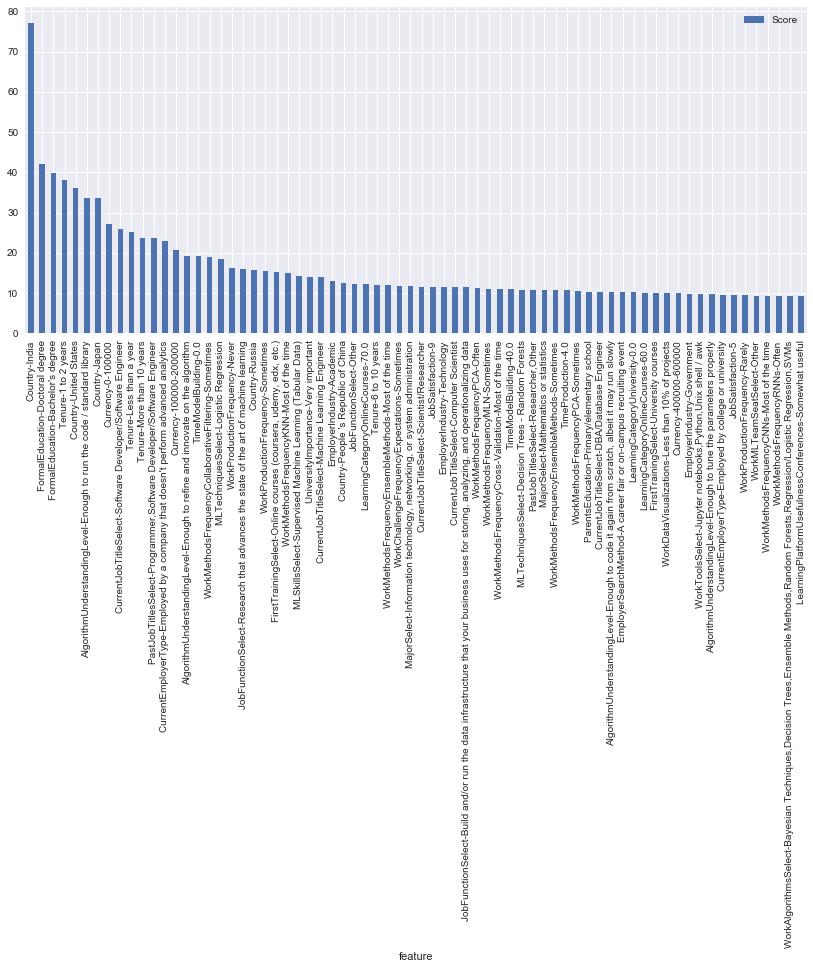

In [36]:
feature_scores.set_index(["feature"]).sort_values(by="Score", ascending=False).plot(figsize=(14,6), kind='bar')

In [37]:
feature_list = feature_scores.feature.tolist()


final_features = features[feature_list]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(final_features.as_matrix(), df[label], test_size=0.2, random_state=0)

In [39]:
len(feature_list)

70

In [40]:
model = LogisticRegression(multi_class='ovr')
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.60361842105263153

In [41]:
model.score(X_test, y_test)

0.57236842105263153

In [42]:
len(feature_scores)

70

In [43]:
top_ten = feature_scores.set_index(["feature"]).sort_values(by="Score", ascending=False).head(10)

In [44]:
top_ten

,Score
feature,
Country-India,77.167104
FormalEducation-Doctoral degree,41.963954
FormalEducation-Bachelor's degree,39.717263
Tenure-1 to 2 years,38.144879
Country-United States,36.073756
AlgorithmUnderstandingLevel-Enough to run the code / standard library,33.635995
Country-Japan,33.635610
Currency-0-100000,27.273167
CurrentJobTitleSelect-Software Developer/Software Engineer,25.987882


So, we have the top 10 features that dictate whether or not someone would call themselves a "Data Scientist" or not.  Let's look into the details of these cohort groups.

In [45]:
top_ten.index

Index(['Country-India', 'FormalEducation-Doctoral degree',
       'FormalEducation-Bachelor's degree', 'Tenure-1 to 2 years',
       'Country-United States',
       'AlgorithmUnderstandingLevel-Enough to run the code / standard library',
       'Country-Japan', 'Currency-0-100000',
       'CurrentJobTitleSelect-Software Developer/Software Engineer',
       'Tenure-Less than a year'],
      dtype='object', name='feature')

In [46]:
cohort_df=features['Country-India']

In [47]:
cohort_df = features[top_ten.index]

In [53]:
cohort_df.columns

Index(['Country-India', 'FormalEducation-Doctoral degree',
       'FormalEducation-Bachelor's degree', 'Tenure-1 to 2 years',
       'Country-United States',
       'AlgorithmUnderstandingLevel-Enough to run the code / standard library',
       'Country-Japan', 'Currency-0-100000',
       'CurrentJobTitleSelect-Software Developer/Software Engineer',
       'Tenure-Less than a year'],
      dtype='object')

In [54]:
cohort_df = pd.concat([cohort_df, df[label]], axis=1)

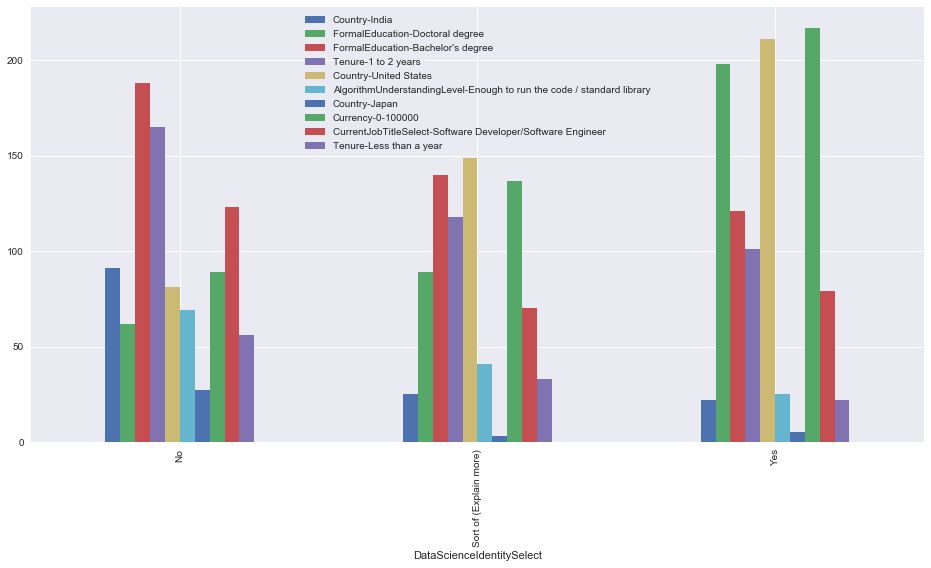

In [55]:
cohort_df.groupby(['DataScienceIdentitySelect']).sum().plot(figsize=(16,8),kind='bar')

In [ ]:
cohort_df = pd.concat([cohort_df, df[label]], axis=1)

In [81]:
ds_yes = df[df[label]=='Yes']
ds_no = df[df[label]=='No']
ds_sort_of = df[df[label]=='Sort of (Explain more)']

In [87]:
df.groupby(["FormalEducation", label])[label].count().unstack()

DataScienceIdentitySelect,No,Sort of (Explain more),Yes
FormalEducation,,,
0,197.0,NaN,NaN
Bachelor's degree,104.0,140.0,121.0
Doctoral degree,36.0,89.0,198.0
I prefer not to answer,NaN,NaN,3.0
Master's degree,127.0,172.0,287.0
Some college/university study without earning a bachelor's degree,16.0,13.0,17.0


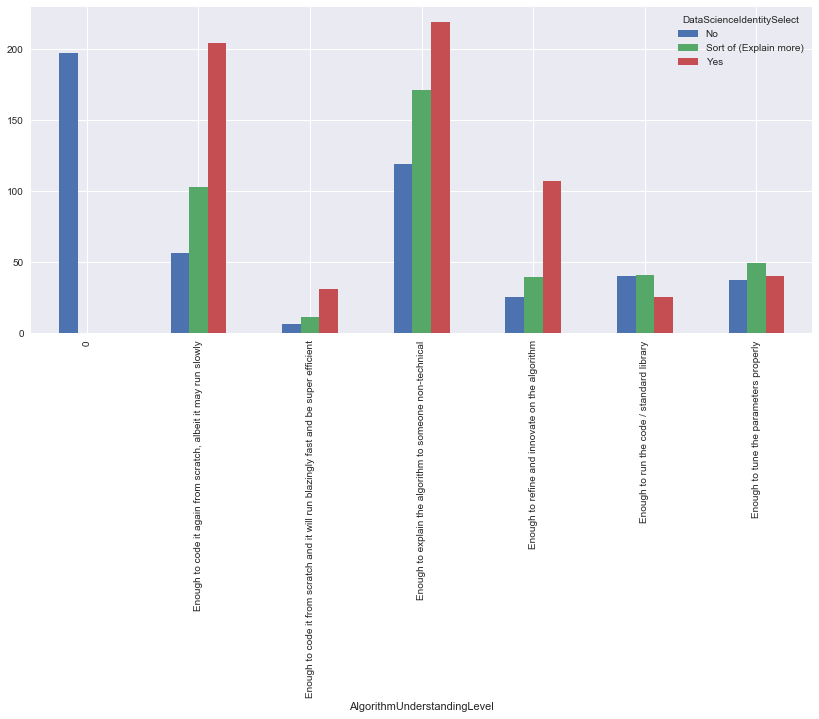

In [93]:
df.groupby(["AlgorithmUnderstandingLevel", label])[label].count().unstack().plot(kind='bar',figsize=(14,6))

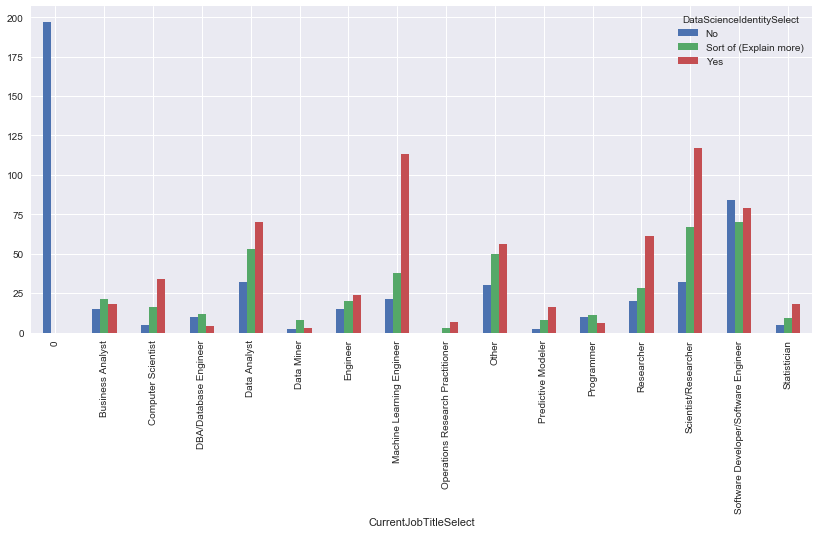

In [94]:
df.groupby(["CurrentJobTitleSelect", label])[label].count().unstack().plot(kind='bar',figsize=(14,6))

The results of this analysis were interesting.  A few features stood out that would help to identify people who consider themselves "Data Scientists".  First, this cohort has a strong representative population that has Doctoral Degrees.  While certainly not necessary for job functionality, it is a defining characteristic of this population.  Additionally, having the job title of "Software Developer" or "Software Engineer" is also a shown to identiy people that call themselves Data Scientists.  One of the interesting questions on the survey was:

At which level do you understand the mathematics behind the algorithms you use at work?

The answers available for selection were:

In [96]:
df['AlgorithmUnderstandingLevel'].value_counts()

Enough to explain the algorithm to someone non-technical                                509
Enough to code it again from scratch, albeit it may run slowly                          363
0                                                                                       197
Enough to refine and innovate on the algorithm                                          171
Enough to tune the parameters properly                                                  126
Enough to run the code / standard library                                               106
Enough to code it from scratch and it will run blazingly fast and be super efficient     48
Name: AlgorithmUnderstandingLevel, dtype: int64

The cohort identified their understanding mostly as:

Enough to explain the algorithm to someone non-technical  
Enough to code it again from scratch, albeit it may run slowly

That seems technical enough, but the results of the feature selection indicated that the feature, Enough to run the code/standard library was a better feature to identify a member of the cohort.  This would indicate that people who only understand the algorithms enough to run the code/standard library would not have a high-enough understanding to call themselves "Data Scientists".

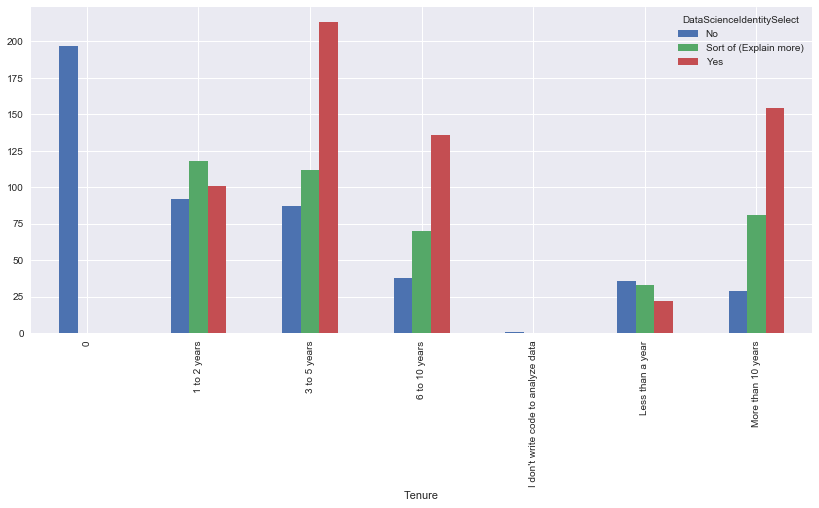

In [99]:
df.groupby(["Tenure", label])[label].count().unstack().plot(kind='bar',figsize=(14,6))

Additionally, while the feature of Tenure '1 to 2 years' was critical in identifying the cohort, it is clear that people that refer to themselves as "Data Scientists" have longer Tenure, three years and greater.

In conclusion, people that call themselves "Data Scientists" have at least 3 years of experience, understand the algorithms on a deeper level, and have a job title of Software Engineer/Developer, Research Scientist, Data Analyst or Machine Learning Engineer. 